# LAB 5.1 Multiscale Unsharp Masking

In [2]:
import cv2
import numpy as np,sys
import matplotlib.pyplot as plt 
from skimage.io import imread

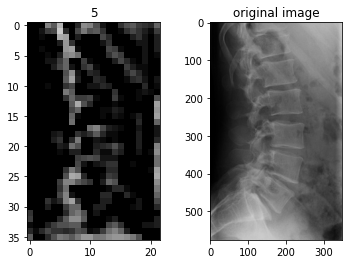

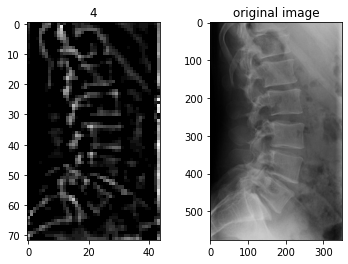

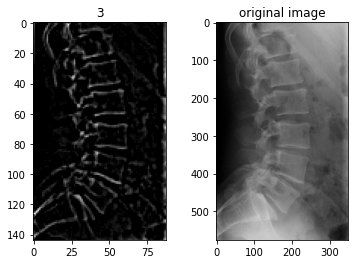

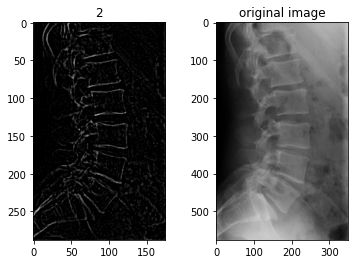

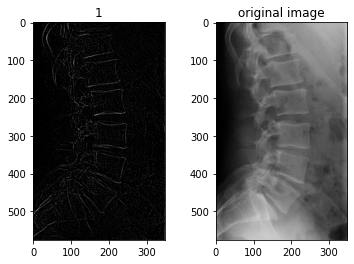

In [6]:

img = cv2.imread("/Users/kunanonjarat/Downloads/spine2.jpg")

# Gaussian Pyramid
layer = img.copy()
gaussian_pyramid = [layer]
for i in range(6):
    layer = cv2.pyrDown(layer)
    gaussian_pyramid.append(layer)

# Laplacian Pyramid
layer = gaussian_pyramid[5]
#image = cv2.cvtColor(layer,cv2.COLOR_BGR2RGB)
#plt.imshow(image), plt.title("Layer")
laplacian_pyramid = [layer]
for i in range(5, 0, -1):
    size = (gaussian_pyramid[i-1].shape[1], gaussian_pyramid[i-1].shape[0])
    gaussian_expanded = cv2.pyrUp(gaussian_pyramid[i], dstsize=size)
    laplacian = cv2.subtract(gaussian_pyramid[i-1], gaussian_expanded)
    laplacian_pyramid.append(laplacian)
    plt.figure()
    plt.subplot(1,2,1), plt.imshow(cv2.cvtColor(10*laplacian, cv2.COLOR_BGR2RGB)), plt.title(str(i))
    plt.subplot(1,2,2), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title("original image") 
    cv2.imshow(str(i), 10*laplacian)
    cv2.waitKey(0)
cv2.imshow(str(i), 10*laplacian)
cv2.imshow("Original image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:
A = cv2.imread("/Users/kunanonjarat/Downloads/spine2.jpg")
B = cv2.imread("/Users/kunanonjarat/Downloads/spine2.jpg")

# generate Gaussian pyramid for A
layer = A.copy()
gaussian_pyramid_a = [layer]
for i in range(6):
    layer = cv2.pyrDown(layer)
    gaussian_pyramid_a.append(layer)

# generate Gaussian pyramid for B
layer =B.copy()
gaussian_pyramid_b = [layer]
for i in range(6):
    layer = cv2.pyrDown(layer)
    gaussian_pyramid_b.append(layer)

    
# Laplacian Pyramid
layer_a = gaussian_pyramid_a[5]
#cv2.imshow("6", layer)
laplacian_pyramid_a = [layer_a]
for i in range(5, 0, -1):
    size = (gaussian_pyramid_a[i-1].shape[1], gaussian_pyramid_a[i-1].shape[0])
    gaussian_expanded_a = cv2.pyrUp(gaussian_pyramid_a[i], dstsize=size)
    laplacian_a = cv2.subtract(gaussian_pyramid_a[i-1], gaussian_expanded_a)
    laplacian_pyramid_a.append(laplacian_a)
# Laplacian Pyramid
layer = gaussian_pyramid_b[5]
#cv2.imshow("6", layer)
laplacian_pyramid_b = [layer]
for i in range(5, 0, -1):
    size = (gaussian_pyramid_b[i-1].shape[1], gaussian_pyramid_b[i-1].shape[0])
    gaussian_expanded_b = cv2.pyrUp(gaussian_pyramid_b[i], dstsize=size)
    laplacian_b = cv2.subtract(gaussian_pyramid_b[i-1], gaussian_expanded_b)
    laplacian_pyramid_b.append(laplacian_b)
    

(<AxesSubplot:title={'center':'original image'}>,
 Text(0.5, 1.0, 'original image'))

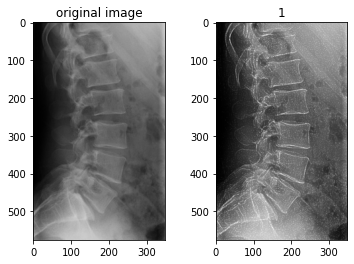

In [7]:
sharpended = img + 10*laplacian
plt.subplot(1,2,2), plt.imshow(cv2.cvtColor(sharpended, cv2.COLOR_BGR2RGB)), plt.title(str(i))
plt.subplot(1,2,1), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title("original image") 

# LAB 5.2 Pyramid based Image Blending

In [1]:
import cv2
import numpy as np
 
 
# Step-2
# Find the Gaussian pyramid of the two images and the mask
def gaussian_pyramid(img, num_levels):
    lower = img.copy()
    gaussian_pyr = [lower]
    for i in range(num_levels):
        lower = cv2.pyrDown(lower)
        gaussian_pyr.append(np.float32(lower))
    return gaussian_pyr
 
# Step-3
# Then calculate the Laplacian pyramid
def laplacian_pyramid(gaussian_pyr):
    laplacian_top = gaussian_pyr[-1]
    num_levels = len(gaussian_pyr) - 1
    
    laplacian_pyr = [laplacian_top]
    for i in range(num_levels,0,-1):
        size = (gaussian_pyr[i - 1].shape[1], gaussian_pyr[i - 1].shape[0])
        gaussian_expanded = cv2.pyrUp(gaussian_pyr[i], dstsize=size)
        laplacian = np.subtract(gaussian_pyr[i-1], gaussian_expanded)
        laplacian_pyr.append(laplacian)
    return laplacian_pyr
 
# Step-4
# Now blend the two images wrt. the mask
def blend(laplacian_A,laplacian_B,mask_pyr):
    LS = []
    for la,lb,mask in zip(laplacian_A,laplacian_B,mask_pyr):
        ls = lb * mask + la * (1.0 - mask)
        LS.append(ls)
    return LS
 
# Step-5
# Reconstruct the original image
def reconstruct(laplacian_pyr):
    laplacian_top = laplacian_pyr[0]
    laplacian_lst = [laplacian_top]
    num_levels = len(laplacian_pyr) - 1
    for i in range(num_levels):
        size = (laplacian_pyr[i + 1].shape[1], laplacian_pyr[i + 1].shape[0])
        laplacian_expanded = cv2.pyrUp(laplacian_top, dstsize=size)
        laplacian_top = cv2.add(laplacian_pyr[i+1], laplacian_expanded)
        laplacian_lst.append(laplacian_top)
    return laplacian_lst
 
# Now let's call all these functions
if __name__ == '__main__':
    # Step-1
    # Load the two images
    img1 = cv2.imread('/Users/kunanonjarat/Downloads/cloud1.jpg')
    img1 = cv2.resize(img1, (1800, 1000))
    img2 = cv2.imread('/Users/kunanonjarat/Downloads/jet.jpg')
    img2 = cv2.resize(img2, (1800, 1000))
 
    # Create the mask
    mask = np.zeros((1000,1800,3), dtype='float32')
    mask[250:500,640:1440,:] = (1,1,1)
    
    num_levels = 7
    
    # For image-1, calculate Gaussian and Laplacian
    gaussian_pyr_1 = gaussian_pyramid(img1, num_levels)
    laplacian_pyr_1 = laplacian_pyramid(gaussian_pyr_1)
    # For image-2, calculate Gaussian and Laplacian
    gaussian_pyr_2 = gaussian_pyramid(img2, num_levels)
    laplacian_pyr_2 = laplacian_pyramid(gaussian_pyr_2)
    # Calculate the Gaussian pyramid for the mask image and reverse it.
    mask_pyr_final = gaussian_pyramid(mask, num_levels)
    mask_pyr_final.reverse()
    # Blend the images
    add_laplace = blend(laplacian_pyr_1,laplacian_pyr_2,mask_pyr_final)
    # Reconstruct the images
    final  = reconstruct(add_laplace)
    # Save the final image to the disk
    s = cv2.imwrite('/Users/kunanonjarat/Downloads/tothemoon.jpg',final[num_levels])
    cv2_imshow(s)

NameError: name 'cv2_imshow' is not defined

#  Discussions

Ans: 
        5.1 Picture look more clearly from original one.
        5.2 To blend any image into some picture we need a similar background to make them compatible.